In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from itertools import product

import cartopy
import cartopy.crs as ccrs
import cmocean
import constants
import dask
import data_collections as dc
import funnel
import intake
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import metabolic as mi
import numpy as np
import pandas as pd
import util
import xarray as xr

/glade/work/mclong/miniconda3/envs/metabolic/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
try:
    cluster
    client
except:
    cluster, client = util.get_ClusterClient(memory='16GB')
    cluster.scale(32)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/asm/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/asm/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.52:33353,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/asm/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Load dataset

Read the collection of datasets to support this computation. First step, connect to the local catalog; this contains datasets computed elsewhere in the project.

In [4]:
curator = util.curator_local_assets()
cat = curator.open_catalog()
curator

dict_keys(['ASM-Tmax-1x1', 'cesm-le-epoch-means', 'cesm-le-global-ts', 'trait-space', 'trait-space-hires', 'viable-traits-mask-cesm-1x1', 'viable-traits-mask-woa2018', 'woa2018', 'zonal-safety-margin-metrics-cesm1x1', 'zonal-safety-margin-metrics-woa2018'])

### Observationally-based trait viability

Trait viability data computed from the WOA2018

In [5]:
%%time
key = 'viable-traits-mask-woa2018'
print(f'{key}: {cat[key].description}\n')
ds_obs = cat[key].to_dask().load()
ds_obs['vol'] = ds_obs.dz * ds_obs.area
ds_obs

viable-traits-mask-woa2018: 
        Viable traits mask computed from woa2018 by compute-viable-traits.ipynb
        Viability criteria: 
          - via_Phi: 1 < mean(Phi) < 2
          - via_ATmax: mean(T) < ATmax
        

CPU times: user 5.13 s, sys: 17.4 s, total: 22.6 s
Wall time: 33.7 s


<xarray.Dataset>
Dimensions:            (Ac: 12, Eo: 11, Ao: 12, depth: 47, lat: 180, lon: 360)
Coordinates:
  * Ac                 (Ac) float64 0.03 0.037 0.0456 ... 0.1974 0.2433 0.3
  * Ao                 (Ao) float64 0.06811 0.08867 0.1147 ... 0.784 0.9872
  * Eo                 (Eo) float64 -0.5 -0.3056 -0.1111 ... 0.8611 1.056 1.25
  * depth              (depth) float32 0.0 5.0 10.0 15.0 ... 900.0 950.0 1e+03
  * lat                (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon                (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Data variables:
    ATmax_active       (Ac, Eo) float64 nan nan nan nan ... 27.2 25.63 24.37
    ATmax_resting      (Ao, Eo) float64 42.49 35.22 29.01 ... 33.29 31.24 29.54
    Phi_active         (Ac, Eo, depth, lat, lon) float64 nan nan ... 49.65 49.65
    Phi_resting        (Ao, Eo, depth, lat, lon) float64 nan nan ... 163.4 163.4
    area               (lat, lon) float64 1.079e+08 1.079e+08 ... 1.079e+08
    dz                 (depth) float32 2.5 5.0 5.0 5.0 ... 50.0 50.0 50.0 50.0
    trait_spc_active   (Ac, Eo) float64 0.0001004 0.0006727 ... 6.159e-06
    trait_spc_resting  (Ao, Eo) float64 0.0001098 0.0007361 ... 5.384e-06
    viability_active   (Ac, Eo, depth, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0
    viability_resting  (Ao, Eo, depth, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0
    vol                (depth, lat, lon) float64 2.697e+08 ... 5.395e+09

### CESM-LE trait viability data

Trait viability and Aerobic Safety Margin data computed from CESM.

In [6]:
%%time
keys = ["ASM-Tmax-1x1", "viable-traits-mask-cesm-1x1"]
for key in keys:
    print(f"{key}: {cat[key].description}")
ds_asm = xr.merge([cat[key].to_dask() for key in keys])  # .load()
ds_asm['vol'] = ds_asm.dz * ds_asm.area
ds_asm

ASM-Tmax-1x1: ASM maximum temperature compute-aerobic-safety-margin.ipynb
viable-traits-mask-cesm-1x1: 
        Viable traits mask computed from cesm-1x1 by compute-viable-traits.ipynb
        Viability criteria: 
          - via_Phi: 1 < mean(Phi) < 2
          - via_ATmax: mean(T) < ATmax
        
CPU times: user 101 ms, sys: 14.7 ms, total: 115 ms
Wall time: 1.62 s


<xarray.Dataset>
Dimensions:            (Ac: 12, Eo: 11, z_t: 40, lat: 180, lon: 360, Ao: 12)
Coordinates:
  * Ac                 (Ac) float64 0.03 0.037 0.0456 ... 0.1974 0.2433 0.3
  * Ao                 (Ao) float64 0.06811 0.08867 0.1147 ... 0.784 0.9872
  * Eo                 (Eo) float64 -0.5 -0.3056 -0.1111 ... 0.8611 1.056 1.25
    dz                 (z_t) float32 dask.array<chunksize=(10,), meta=np.ndarray>
  * lat                (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon                (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * z_t                (z_t) float32 500.0 1.5e+03 ... 8.788e+04 9.847e+04
Data variables:
    ASM_Tmax_active    (Ac, Eo, z_t, lat, lon) float64 dask.array<chunksize=(1, 1, 40, 180, 10), meta=np.ndarray>
    ASM_Tmax_resting   (Ao, Eo, z_t, lat, lon) float64 dask.array<chunksize=(1, 1, 40, 180, 10), meta=np.ndarray>
    ATmax_active       (Ac, Eo) float64 dask.array<chunksize=(12, 11), meta=np.ndarray>
    ATmax_resting      (Ao, Eo) float64 dask.array<chunksize=(12, 11), meta=np.ndarray>
    Phi_active         (Ac, Eo, z_t, lat, lon) float64 dask.array<chunksize=(3, 3, 10, 45, 90), meta=np.ndarray>
    Phi_resting        (Ao, Eo, z_t, lat, lon) float64 dask.array<chunksize=(3, 3, 10, 45, 90), meta=np.ndarray>
    area               (lat, lon) float64 dask.array<chunksize=(90, 360), meta=np.ndarray>
    trait_spc_active   (Ac, Eo) float64 dask.array<chunksize=(12, 11), meta=np.ndarray>
    trait_spc_resting  (Ao, Eo) float64 dask.array<chunksize=(12, 11), meta=np.ndarray>
    viability_active   (Ac, Eo, z_t, lat, lon) float64 dask.array<chunksize=(3, 3, 10, 45, 90), meta=np.ndarray>
    viability_resting  (Ao, Eo, z_t, lat, lon) float64 dask.array<chunksize=(3, 3, 10, 45, 90), meta=np.ndarray>
    vol                (z_t, lat, lon) float64 dask.array<chunksize=(10, 90, 360), meta=np.ndarray>

In [7]:
%%time
dsets = dict(
    cesm1x1=ds_asm.chunk({'lat': 1}),
    woa2018=ds_obs,  # .chunk({'lat': 1}),
)

CPU times: user 18.9 s, sys: 490 ms, total: 19.4 s
Wall time: 20.6 s


## Compute trait frequency fields

- Broadcast the trait-frequency distribution to geographic space using the viability mask (e.g., `via_Phi_active`, `via_Phi_resting`, etc.).
- Broadcast `ATmax` (which is purely a function of traits) into geographic space the `.where` operations implicitly adds the depth, latitude, and longitude dimensions add fills in NaNs where the particular trait combination is not viable.

In [8]:
%%time
for ds in dsets.values():

    zdim = 'z_t' if 'z_t' in ds.dims else 'depth'

    # construct a volume weight that sums to 1 over each latitude band
    vol_wgts = ds.vol / ds.vol.sum(['lon', zdim])

    for baseline in ['resting', 'active']:

        # ensure that the trait frequency distribution is normalized to 1
        np.testing.assert_almost_equal(ds[f'trait_spc_{baseline}'].sum(xr.ALL_DIMS), 1.0)

        # compute a trait frequency field:
        # - set to trait occurence frequency where traits are viable
        via_mask = ds[f'viability_{baseline}']
        tw = via_mask * ds[f'trait_spc_{baseline}']
        ds[f'TW_{baseline}'] = tw  # Should I add this here: * vol_wgts?
        ds[f'ATmax_{baseline}'] = ds[f'ATmax_{baseline}'].where(via_mask == 1.0)

    ds['Ac_viable'] = ds.Ac.where(ds.viability_active == 1.0)
    ds['Eo_viable'] = ds.Ac.where(ds.viability_active == 1.0)

dsets

CPU times: user 2.54 s, sys: 2.52 s, total: 5.06 s
Wall time: 5.89 s


{'cesm1x1': <xarray.Dataset>
 Dimensions:            (Ac: 12, Eo: 11, z_t: 40, lat: 180, lon: 360, Ao: 12)
 Coordinates:
   * Ac                 (Ac) float64 0.03 0.037 0.0456 ... 0.1974 0.2433 0.3
   * Ao                 (Ao) float64 0.06811 0.08867 0.1147 ... 0.784 0.9872
   * Eo                 (Eo) float64 -0.5 -0.3056 -0.1111 ... 0.8611 1.056 1.25
     dz                 (z_t) float32 dask.array<chunksize=(10,), meta=np.ndarray>
   * lat                (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
   * lon                (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
   * z_t                (z_t) float32 500.0 1.5e+03 ... 8.788e+04 9.847e+04
 Data variables: (12/14)
     ASM_Tmax_active    (Ac, Eo, z_t, lat, lon) float64 dask.array<chunksize=(1, 1, 40, 1, 10), meta=np.ndarray>
     ASM_Tmax_resting   (Ao, Eo, z_t, lat, lon) float64 dask.array<chunksize=(1, 1, 40, 1, 10), meta=np.ndarray>
     ATmax_active       (Ac, Eo, z_t, lat, lon) float64 dask.array<chunks

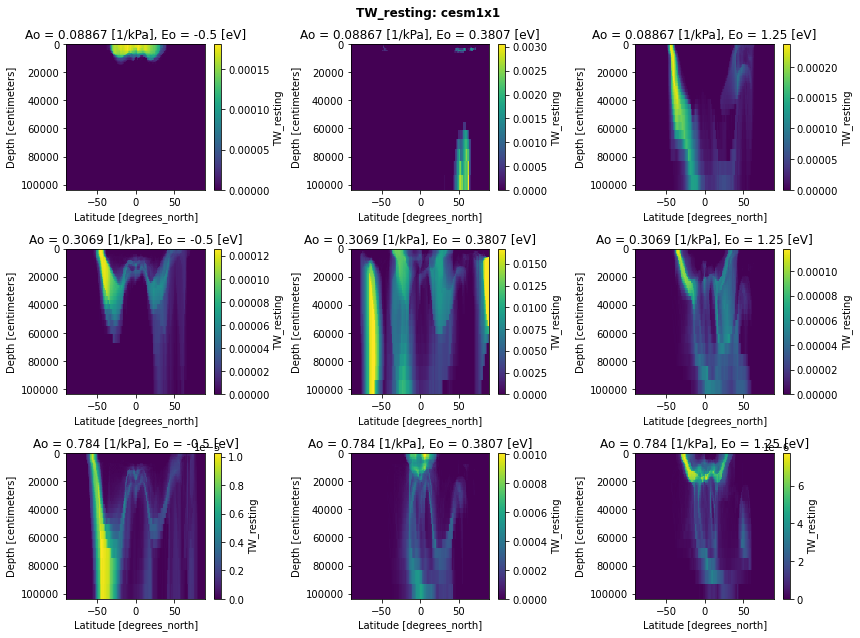

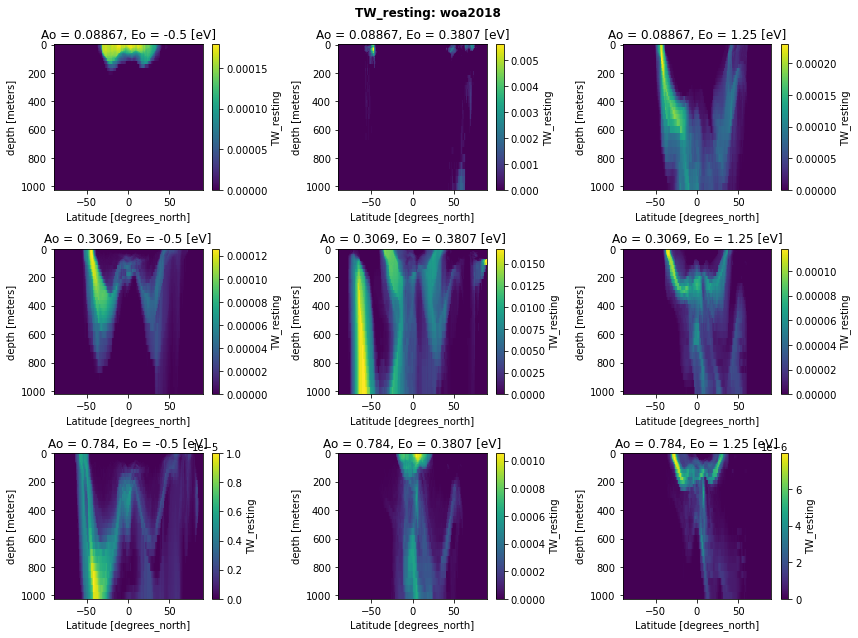

In [9]:
field = 'TW_resting'

for key, ds in dsets.items():

    Eo = ds.Eo.sel(Eo=np.percentile(ds.Eo, [5, 50, 95], interpolation='nearest'))
    Ao = ds.Ao.sel(Ao=np.percentile(ds.Ao, [5, 50, 95], interpolation='nearest'))

    fig, axs = plt.subplots(len(Ao), len(Eo), figsize=(12, 9))
    for i, j in product(range(len(Ao)), range(len(Eo))):
        ds[field].sel(Eo=Eo[j], Ao=Ao[i]).mean('lon').plot(
            yincrease=False,
            ax=axs[i, j],
        )
    plt.suptitle(f'{field}: {key}', fontweight='bold')
    plt.tight_layout();

## Compute zonal distribution of trait-weighted safety margins

Set up temperature bins into which to aggregation trait-frequency.

In [10]:
Tmax_bin_edge = np.arange(0, 64, 2)
Tmax_bin_c = np.vstack((Tmax_bin_edge[:-1], Tmax_bin_edge[1:])).mean(axis=0)
Tmax_bins = xr.DataArray(
    Tmax_bin_c,
    dims=('Tmax'),
    coords={'Tmax': Tmax_bin_c},
)
Tmax_bins

<xarray.DataArray (Tmax: 31)>
array([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19., 21., 23., 25.,
       27., 29., 31., 33., 35., 37., 39., 41., 43., 45., 47., 49., 51.,
       53., 55., 57., 59., 61.])
Coordinates:
  * Tmax     (Tmax) float64 1.0 3.0 5.0 7.0 9.0 ... 53.0 55.0 57.0 59.0 61.0

Scatter datasets

In [11]:
%%time
dsets_fut = {k: ds.chunk({'lat': 1}).persist() for k, ds in dsets.items()}

CPU times: user 5min 21s, sys: 13.8 s, total: 5min 35s
Wall time: 5min 46s


In [12]:
%%time


@dask.delayed
def groupby_bins(ds_j, v, wgt_var):
    """bin data"""

    if ds_j[v].isnull().all():
        return xr.DataArray(
            np.ones((1, len(Tmax_bins))) * 0.0,  # np.nan,
            dims=("lat", "Tmax"),
            coords={"Tmax": Tmax_bins, "lat": [np.float64(ds_j.lat)]},
        )

    g_sum = ds_j.groupby_bins(v, Tmax_bin_edge).sum(xr.ALL_DIMS)
    da_out = (
        g_sum[wgt_var]
        .expand_dims({"lat": [np.float64(ds_j.lat)]})
        .rename({f"{v}_bins": "Tmax"})
        .transpose("lat", "Tmax")
        .fillna(0.0)
    )
    da_out["Tmax"] = Tmax_bins
    return da_out


Tmax_metrics_trait_wgt = dict(
    ATmax_resting='TW_resting',
    ATmax_active='TW_active',
    ASM_Tmax_active='TW_active',
    ATmax_resting_viaATmax='TW_resting',
    Ac_viable='TW_active',
    Eo_viable='TW_active',
)

dsets_out = {}
for key, ds in dsets_fut.items():

    dsets_out[key] = xr.Dataset()

    objs = {}
    for Tmax_metric_var, trait_wgt_var in Tmax_metrics_trait_wgt.items():

        if 'woa' in key and 'ASM' in Tmax_metric_var:
            continue

        objs[Tmax_metric_var] = [
            groupby_bins(ds.isel(lat=j), Tmax_metric_var, trait_wgt_var)
            for j in range(ds.sizes["lat"])
        ]

    for Tmax_metric_var in objs.keys():
        dsets_out[key][Tmax_metric_var] = xr.concat(dask.compute(*objs[Tmax_metric_var]), dim="lat")

dsets_out['woa2018']

distributed.scheduler - ERROR - Error transitioning "('where-7a32c57d4665113c2c31e0f12941eb44', 0, 1, 2, 76, 3)" from 'erred' to 'memory'
Traceback (most recent call last):
  File "/glade/work/mclong/miniconda3/envs/metabolic/lib/python3.7/site-packages/distributed/scheduler.py", line 2280, in _transition
    assert not args and not kwargs, (args, kwargs, start_finish)
AssertionError: ((), {'worker': 'tcp://10.12.206.38:35224', 'nbytes': 64800, 'typename': 'numpy.ndarray'}, ('erred', 'memory'))
distributed.utils - ERROR - ((), {'worker': 'tcp://10.12.206.38:35224', 'nbytes': 64800, 'typename': 'numpy.ndarray'}, ('erred', 'memory'))
Traceback (most recent call last):
  File "/glade/work/mclong/miniconda3/envs/metabolic/lib/python3.7/site-packages/distributed/utils.py", line 680, in log_errors
    yield
  File "/glade/work/mclong/miniconda3/envs/metabolic/lib/python3.7/site-packages/distributed/scheduler.py", line 4455, in add_worker
    typename=types[key],
  File "/glade/work/mclong/mi

AttributeError: 'NoneType' object has no attribute 'address'

In [13]:
ds_CTmax = mi.open_CTmax_data()
ds_CTmax

<xarray.Dataset>
Dimensions:        (N: 108, percentile: 21)
Coordinates:
  * percentile     (percentile) uint8 0 5 10 15 20 25 30 ... 75 80 85 90 95 100
Dimensions without coordinates: N
Data variables:
    lat            (N) float64 21.03 27.93 60.65 55.18 ... 0.0 -60.79 34.1
    lat_dist       (N, percentile) float64 19.08 19.28 19.73 ... 50.0 63.66
    Thabitat_dist  (N, percentile) float64 19.45 20.41 22.86 ... 23.56 29.03
    CTmax          (N) float64 40.3 41.8 15.0 25.02 25.0 ... 10.0 43.0 9.0 29.0
    Species        (N) object 'Kuhlia sandvicensis' ... 'Phronima sedentaria'
    Phylum         (N) object 'Chordata' 'Chordata' ... 'Chordata' 'Arthropoda'

In [14]:
ds = dsets_out['woa2018']
v = 'ATmax_resting'
fig, axs = plt.subplots(figsize=(8, 4))
p = ds[v].T.plot()
ax = p.axes
ax.set_ylim([10, 60])

# k = np.where(ds_CTmax.lat != 0)[0]
ax.plot(ds_CTmax.lat, ds_CTmax.CTmax, 'k.')
ax.set_xticks([-50, 0, 50])

KeyError: 'woa2018'

In [ ]:
ds = dsets_out['woa2018']
v = 'ATmax_active'
fig, axs = plt.subplots(figsize=(8, 4))
p = ds[v].T.plot()
ax = p.axes
ax.set_ylim([10, 60])

# k = np.where(ds_CTmax.lat != 0)[0]
ax.plot(ds_CTmax.lat, ds_CTmax.CTmax, 'k.')
ax.set_xticks([-50, 0, 50])

In [ ]:
%%time

clobber = True

this_notebook = 'compute-zonal-safety-margin-metrics.ipynb'

curator = util.curator_local_assets()

for ds_key, dso in dsets_out.items():
    key = f'zonal-safety-margin-metrics-{ds_key}'

    if clobber:
        cache_file = f'{dc.cache_dir}/{key}.zarr'
        os.makedirs(os.path.dirname(cache_file), exist_ok=True)
        dso.to_zarr(cache_file, mode='w', consolidated=True)

        curator.add_source(
            key=key,
            urlpath=cache_file,
            description=f'Zonal safety margin metrics computed from {ds_key} by {this_notebook}',
            driver='zarr',
            overwrite=True,
        )

In [ ]:
dso.nbytes / 1024 ** 3